In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import geopandas as gp
import sys

sys.path.insert(0, "../Notebooks/Functions")
import StatsFunctions as MF

In [44]:
Literacy = pd.read_html("../Data/HTML data/Literacy Rate by Country 2023 - Wisevoter.html")[0]

,#,Country,Literacy Rate
0,1,Andorra,100%
1,2,Finland,100%
2,3,Liechtenstein,100%
3,4,Luxembourg,100%
4,5,North Korea,100%
...,...,...,...
199,200,Central African Republic,36.75%
200,201,Mali,33.07%
201,202,South Sudan,31.98%
202,203,Guinea,30.47%


In [52]:
x = np.array([-1000, 0, 1000, 2000, 3000])
y = np.array([0, 1e-10, 1e-5, 1e-3, 1e-1])
slope, intercept, _ = MF.linear_regression(x, y)
slope, intercept

(2.009999999e-05, 0.00010200003000000041)

In [6]:
Countries = pd.read_excel(
    "../Data/UNDP data/HDR21-22_Statistical_Annex_HDI_Table.xlsx",
    sheet_name="Table 1",
    header=5,
    usecols="B:C",
    nrows=201,
)

In [7]:
Countries = Countries.dropna().query("Value != '..'")["Country"].reset_index(drop=True)

In [9]:
Rest = pd.read_excel(
    "../Data/UNDP data/HDR21-22_Statistical_Annex_HDI_Table.xlsx",
    sheet_name="Table 1",
    header=4,
    usecols="C,E,G,I,K,M,O",
    nrows=198,
)

In [10]:
Rest = Rest.dropna().drop(index=1, axis=1).reset_index(drop=True)

In [11]:
IQ = pd.read_html("../Data/HTML data/Countries by Average IQ 2023.html")[-1]
Literacy = pd.read_html("../Data/HTML data/Literacy Rate By Country 2023.html")[-1]

In [12]:
combined1 = pd.merge(left=IQ, right=Literacy, on="Region", how = "outer")
combined2 = pd.concat([Countries, Rest], axis=1)

In [13]:
combined1["Literacy Rate"] = combined1["Literacy Rate"].str.removesuffix("%")


In [14]:
combined2["Country"].replace(
    {
        "Viet Nam": "Vietnam",
        "Korea (Republic of)": "South Korea",
        "Türkiye": "Turle",
        "Russian Federation": "Russia",
        "Iran (Islamic Republic of)": "Iran",
        "Moldova (Republic of)": "Moldova",
        "Palestine, State of":"Palestine",
        "Venezuela (Bolivarian Republic of)": "Venezuela",
        "Bolivia (Plurinational State of)":"Bolivia",
        "Syrian Arab Republic": "Syria"
        
        
    },
    inplace=True,
)

combined1["Region"].replace({"Czech Republic": "Czechia", "Republic of the Congo": "Congo"}, inplace=True)

In [15]:
DF = pd.merge(
    left=combined1, right=combined2, how="outer", left_on="Region", right_on="Country"
)

In [16]:
DF.rename(
    {
        "Human Development Index (HDI) ": "HDI",
        "Life expectancy at birth": "LifeExpectancy",
        "Expected years of schooling": "ExpectedYearsOfScholing",
        "Mean years of schooling": "MeanYearsOfSchooling",
        "Gross national income (GNI) per capita": "GNI",
        "Average IQ": "IQ",
        "Literacy Rate": "Literacy"
    },
    axis=1,
    inplace=True,
)

In [17]:
DF = DF.astype(
    {
        "HDI": "float",
        "LifeExpectancy": "float",
        "ExpectedYearsOfScholing": "float",
        "MeanYearsOfSchooling": "float",
        "GNI": "float",
        "GNI per capita rank minus HDI rank": "float",
        "HDI rank": "float",
        "IQ": "float",
        "Literacy": "float"
    }
)

Had a quick glance at the correlation, just for myself, as didn't know if any of those factors are correlated.

Turns out that most of them are correlated, so further investigation needed


In [18]:
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))


C:\Users\dima1\AppData\Local\Temp\ipykernel_2288\20647279.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))


In [19]:
d1 = pd.merge(left = world[["continent", "name", "pop_est", "iso_a3", "geometry"]], right = DF, left_on = "name", right_on="Region")

In [20]:
d2 = pd.merge(left = world[["continent", "name", "pop_est", "iso_a3", "geometry"]], right = DF, left_on = "name", right_on="Country")

In [21]:
DF = pd.merge(d1, d2, how = "outer").dropna()

In [22]:
DF = DF.rename({"continent": "Continent", "pop_est": "Population"}, axis=1)[
    [
        "Continent",
        "Country",
        "Literacy",
        "iso_a3",
        "geometry",
        "HDI",
        "LifeExpectancy",
        "ExpectedYearsOfScholing",
        "MeanYearsOfSchooling",
        "GNI",
        "IQ"
    ]
]

In [23]:
def heatmap(data, title=""):
    corr = data.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(corr.columns), 1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=45)
    ax.set_yticks(ticks)
    ax.set_xticklabels(corr.columns)
    ax.set_yticklabels(corr.columns)

    matrix = pd.DataFrame(data.corr(method="pearson")).round(2)

    for i in range(len(matrix)):
        for j in range(len(matrix.iloc[0])):
            text = ax.text(j, i, matrix.iloc[i, j], ha="center", va="center", color="w")
    ax.set_title(title, pad=20)

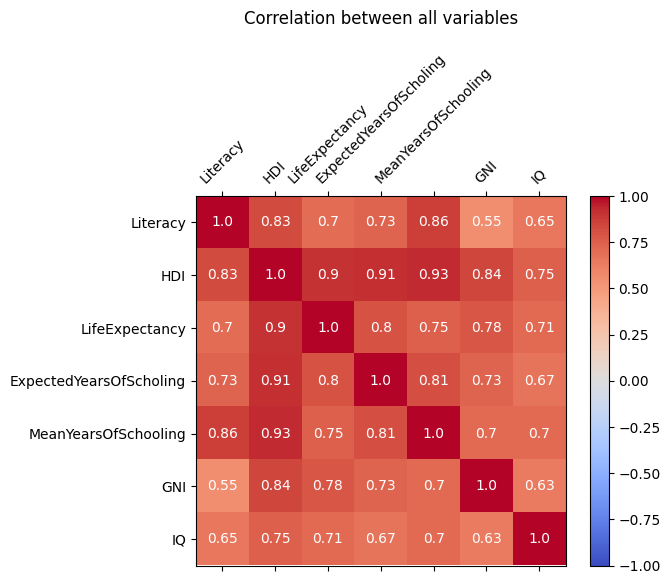

In [24]:
heatmap(
    DF.select_dtypes(include=np.number),
    title="Correlation between all variables",
)

In [25]:
colours = dict(zip(DF["Continent"].unique(), sns.color_palette("bright", 6)))
kwargs = {"hue": "Continent", "palette": colours, "edgecolor": "black", "alpha": 0.6}

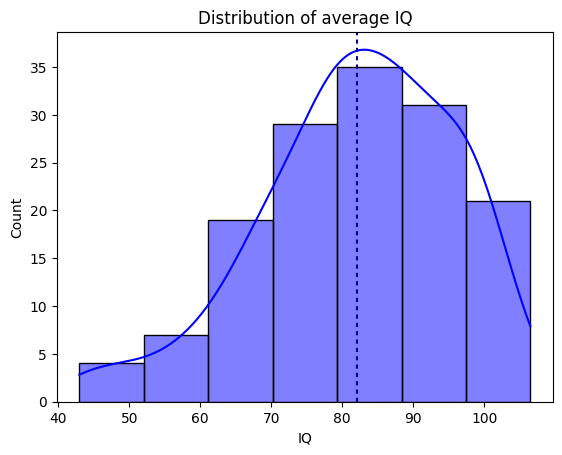

In [26]:
# decided to check average IQ and see how useful it would be
histIQ = sns.histplot(DF, x="IQ", bins=7, kde=True, color="blue")

plt.axvline(
    MF.mean(DF["IQ"]), color="darkblue", label="mean", dashes=(2, 2)
)  

plt.title("Distribution of average IQ")
plt.show()

Text(0.5, 1.0, 'Distribution of IQ for each continent')

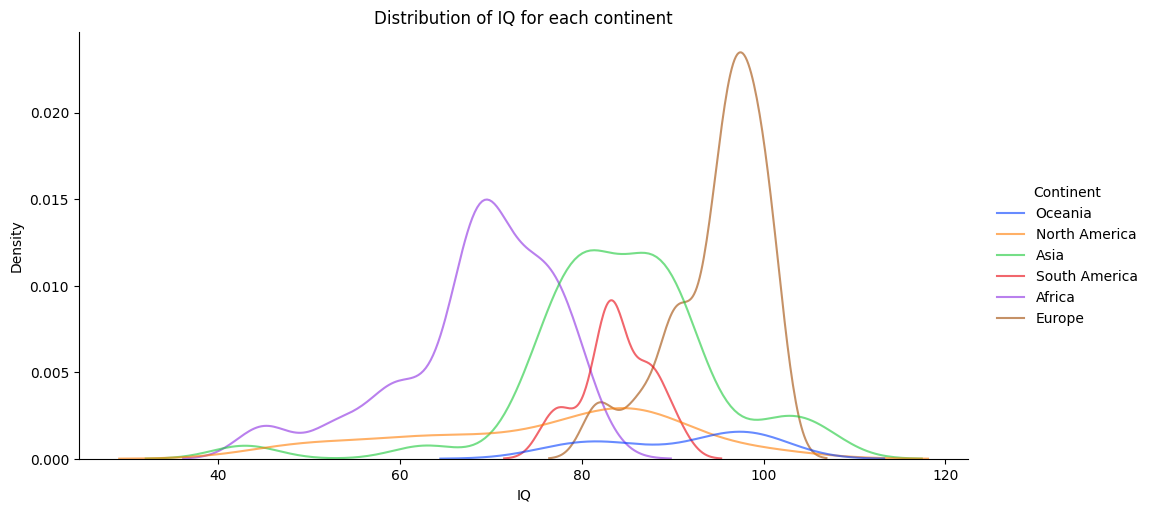

In [27]:
sns.displot(data=DF, x="IQ", **{i:kwargs[i] for i in kwargs if i not in ['edgecolor']}, aspect = 2, kind = "kde", bw_adjust=0.7)

plt.title("Distribution of IQ for each continent")

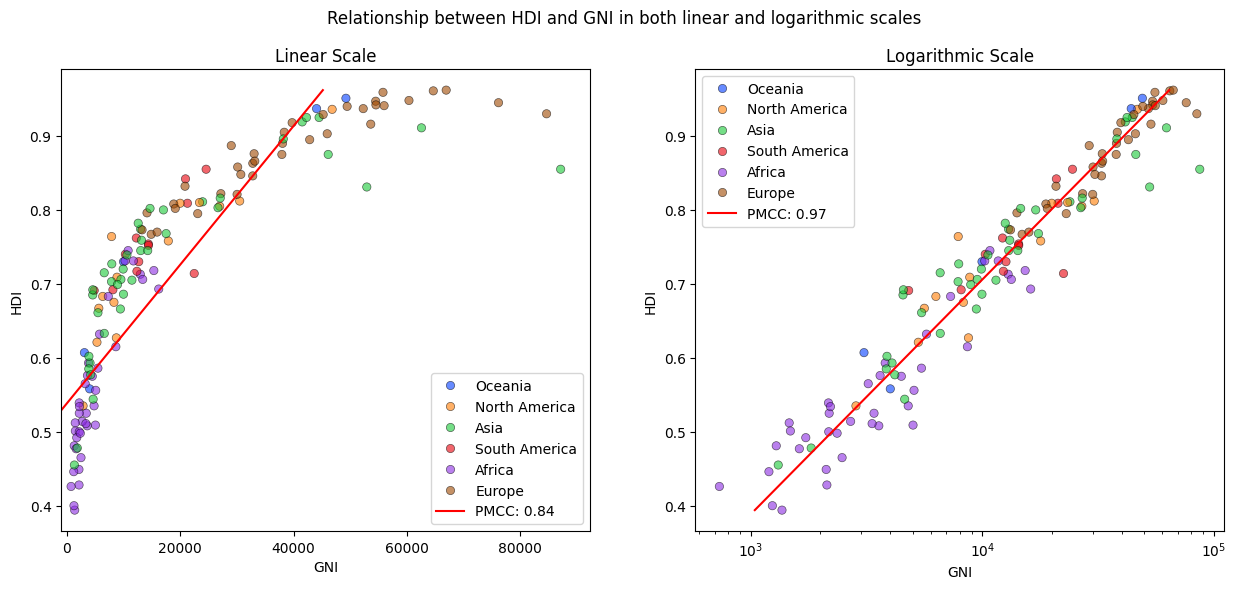

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
m,q, cor = MF.linear_regression(DF["HDI"].to_list(), DF["GNI"].to_list())
m1,q1, cor1 = MF.linear_regression(DF["HDI"].to_list(), np.log10(DF["GNI"].to_list()))
sns.scatterplot(data=DF, x="GNI", y="HDI", **kwargs, ax = axes[0], )  
sns.lineplot(y = DF["HDI"], x = m*DF["HDI"] + q , label = f'PMCC: {round(cor, 2)}', color = "red", ax = axes[0])
axes[0].set_title("Linear Scale")
axes[0].set_xlim((-1000, None))
###
axes[1].set_xscale('log')
X = np.column_stack((np.ones_like(DF["HDI"]), DF["HDI"]))
y_log = np.log(DF["GNI"])
theta = np.linalg.inv(X.T @ X) @ X.T @ y_log
# Predict y values using the linear regression model
y_pred_log = X @ theta

# Plot the linear regression line
sns.scatterplot(data=DF, x="GNI", y="HDI", **kwargs, ax = axes[1])  
sns.lineplot(y = DF["HDI"], x = np.exp(y_pred_log) , label = f'PMCC: {round(cor1, 2)}', color = "red", ax = axes[1])
axes[1].set_title("Logarithmic Scale")

fig.suptitle('Relationship between HDI and GNI in both linear and logarithmic scales')

#more the country invests in people -> they tend to earn and save more money
plt.show()

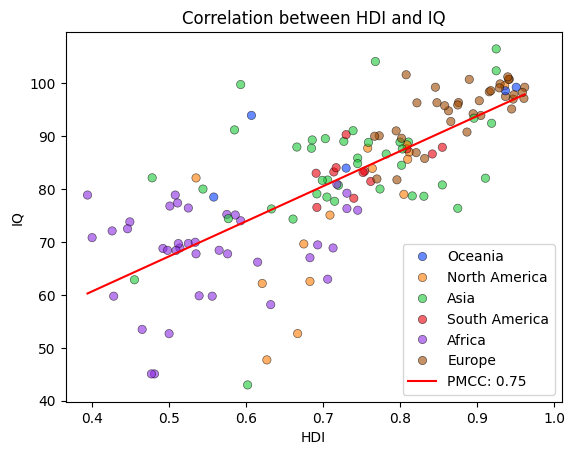

In [29]:
fig, ax = plt.subplots()
m,q, cor = MF.linear_regression(DF["HDI"].to_list(), DF["IQ"].to_list())

sns.scatterplot(data = DF, x = "HDI", y = "IQ", **kwargs)
sns.lineplot(x = DF["HDI"], y = m*DF["HDI"] + q , label = f'PMCC: {round(cor, 2)}', color = "red", ax = ax)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Correlation between HDI and IQ")
plt.xlim((None, 1.01))
plt.show()

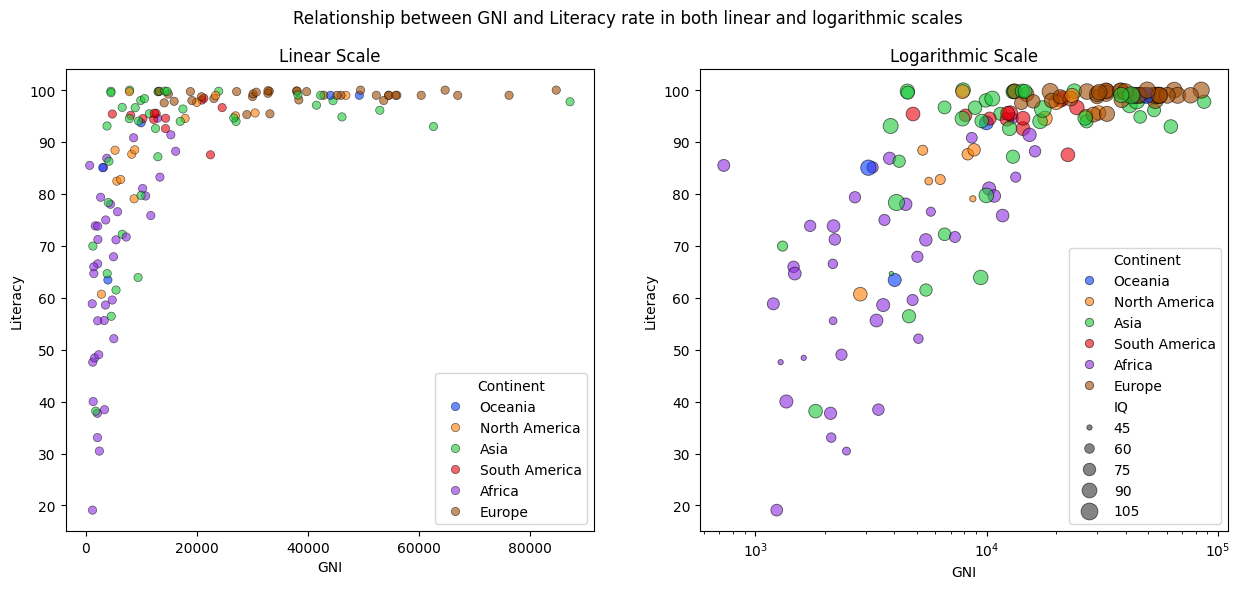

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
m,q, cor = MF.linear_regression(DF["GNI"].to_list(), DF["Literacy"].to_list())
sns.scatterplot(data=DF, y="Literacy", x="GNI", **kwargs, ax = axes[0])  
axes[0].set_title("Linear Scale")

###


# Plot the linear regression line
sns.scatterplot(data=DF, y="Literacy", x="GNI", **kwargs, ax = axes[1], size = "IQ", sizes = (10, 150))  

axes[1].set_title("Logarithmic Scale")
axes[1].set_xscale("log")
fig.suptitle('Relationship between GNI and Literacy rate in both linear and logarithmic scales')

#more money -> access to education -> smarter on average
plt.show()

In [31]:
DF["SchoolingDifference"] = DF["ExpectedYearsOfScholing"] - DF["MeanYearsOfSchooling"]

In [32]:
Continents = DF.groupby("Continent").agg(
    {
        "LifeExpectancy": MF.mean,
        "ExpectedYearsOfScholing": MF.mean,
        "MeanYearsOfSchooling": MF.mean,
        "GNI": "sum",
        "Literacy": MF.mean
    }
)

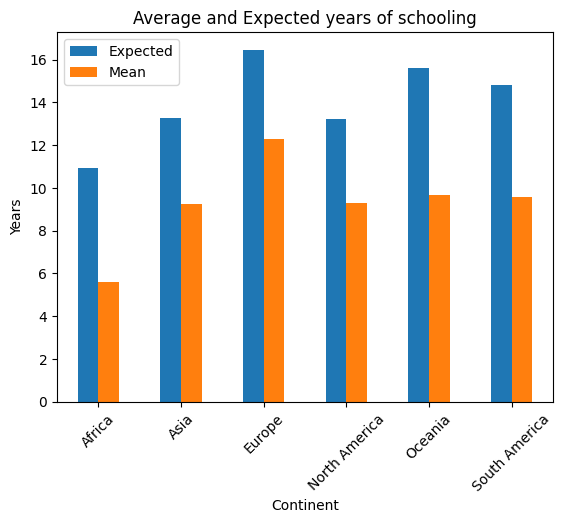

In [33]:
fig, ax = plt.subplots()
Continents.plot.bar(y = ["ExpectedYearsOfScholing", "MeanYearsOfSchooling"], ax = ax)
plt.xticks(rotation = 45)
plt.ylabel("Years")
plt.title("Average and Expected years of schooling")
ax.legend(["Expected", "Mean"])
plt.show()

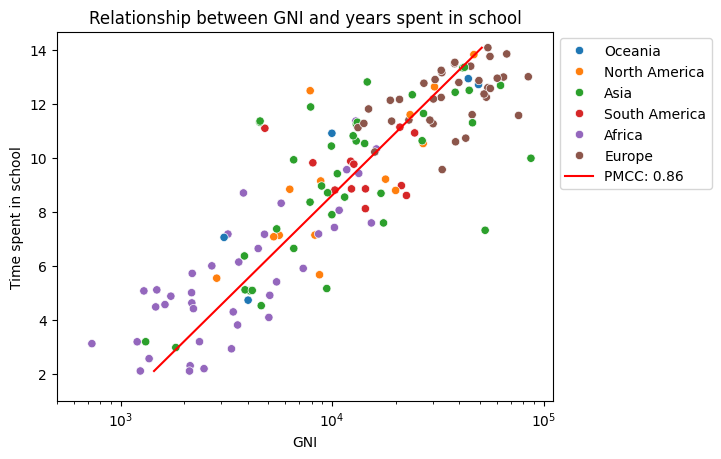

In [34]:
ax = sns.scatterplot(data = DF, x = "GNI", y = "MeanYearsOfSchooling", hue = "Continent")
plt.title("Relationship between GNI and years spent in school")
plt.xscale("log")

m1,q1, cor1 = MF.linear_regression(DF["MeanYearsOfSchooling"].to_list(), np.log10(DF["GNI"].to_list()))


X = np.column_stack((np.ones_like(DF["MeanYearsOfSchooling"]), DF["MeanYearsOfSchooling"]))
y_log = np.log(DF["GNI"])
theta = np.linalg.inv(X.T @ X) @ X.T @ y_log
# Predict y values using the linear regression model
y_pred_log = X @ theta

sns.lineplot( x =np.exp(y_pred_log), y = DF["MeanYearsOfSchooling"], color='red',  label = f'PMCC: {round(cor1, 2)}', ax = ax)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.set_ylabel("Time spent in school")

plt.ylim((1, None))
plt.xlim((500, None))
plt.show()

In [35]:
DF.head(2)

,Continent,Country,Literacy,iso_a3,geometry,HDI,LifeExpectancy,ExpectedYearsOfScholing,MeanYearsOfSchooling,GNI,IQ,SchoolingDifference
0,Oceania,Fiji,93.7,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.730,67.1140,14.736790,10.921548,9980.110866,83.96,3.815242
2,North America,Canada,99.0,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",0.936,82.6565,16.396259,13.834427,46807.986190,99.52,2.561832


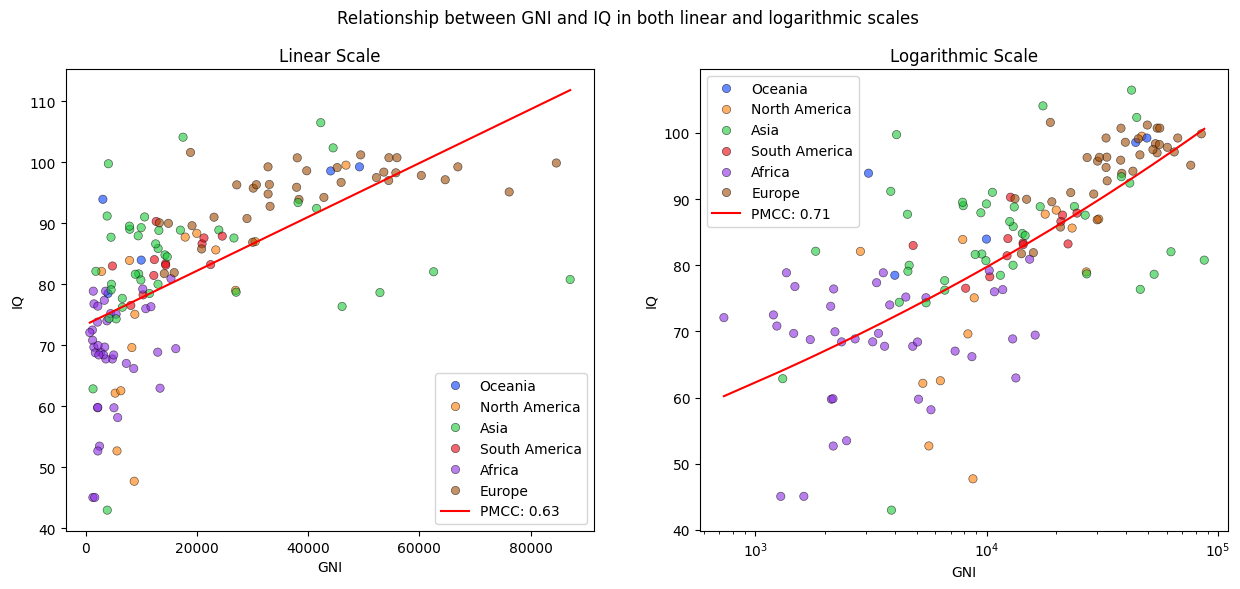

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
m,q, cor = MF.linear_regression(DF["GNI"].to_list(), DF["IQ"].to_list())
sns.scatterplot(data    =DF, y="IQ", x="GNI", **kwargs, ax = axes[0])  
sns.lineplot(x = DF["GNI"], y = m*DF["GNI"] + q , label = f'PMCC: {round(cor, 2)}', color = "red", ax = axes[0])
axes[0].set_title("Linear Scale")



###



m1,q1, cor1 = MF.linear_regression(DF["IQ"].to_list(), np.log10(DF["GNI"].to_list()))
axes[1].set_xscale('log')  # Set x-axis to log scale
X_log = np.column_stack((np.ones_like(np.log(DF["GNI"])), np.log(DF["GNI"])))
y_log = np.log(DF["IQ"])
theta = np.linalg.inv(X_log.T @ X_log) @ X_log.T @ y_log
y_pred_log = X_log @ theta


# Plot the linear regression line
sns.scatterplot(data=DF, y="IQ", x="GNI", **kwargs, ax = axes[1])  
sns.lineplot(x = DF["GNI"], y =np.exp(y_pred_log), color='red',  label = f'PMCC: {round(cor1, 2)}', ax = axes[1])

axes[1].set_title("Logarithmic Scale")

fig.suptitle('Relationship between GNI and IQ in both linear and logarithmic scales')

#more money -> access to education -> smarter on average
plt.show()

Text(0.5, 1.0, 'Distribution of IQ accross regions')

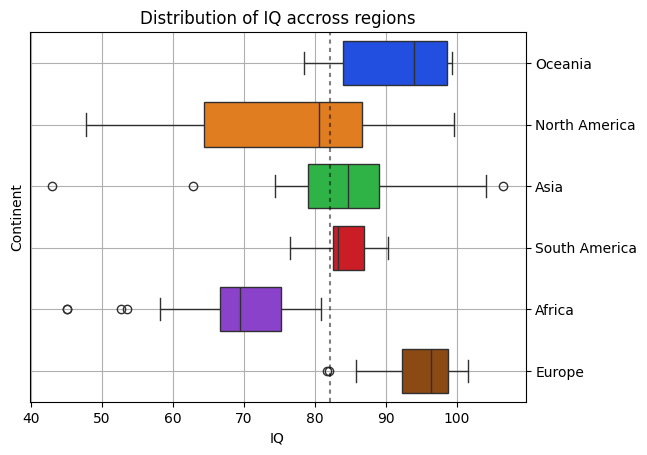

In [37]:
ax = sns.boxplot(
    data=DF,
    x="IQ",
    y="Continent",
    gap=0.4,
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor", "alpha"]},
    legend="auto",
    width=1.2
)
plt.axvline(
    x=MF.mean(DF["IQ"]),
    color="black",
    alpha = 0.5,
    dashes=(2, 2),
)
ax.grid()
# ax.tick_params(axis="y", rotation=45, )
ax.yaxis.tick_right()



plt.title("Distribution of IQ accross regions")

Text(0.5, 1.0, 'Distribution of HDI accross regions')

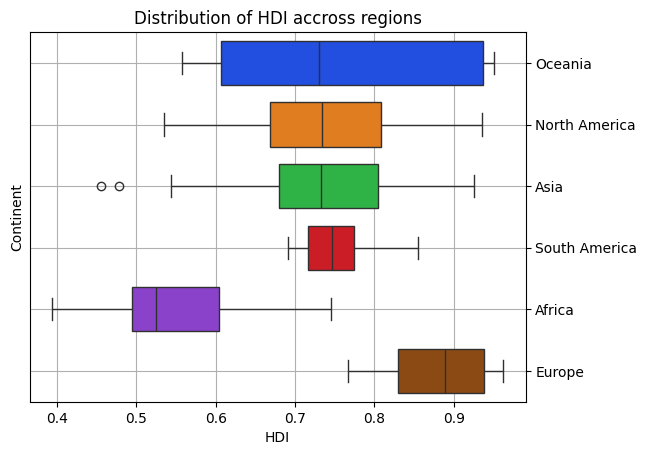

In [38]:
ax = sns.boxplot(
    data=DF,
    x="HDI",
    y="Continent",
    gap=0.4,
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor", "alpha"]},
    legend="auto",
    width=1.2
)

ax.grid()
# ax.tick_params(axis="y", rotation=45, )
ax.yaxis.tick_right()


plt.title("Distribution of HDI accross regions")

Text(0.5, 1.0, 'Distribution of GNI accross regions')

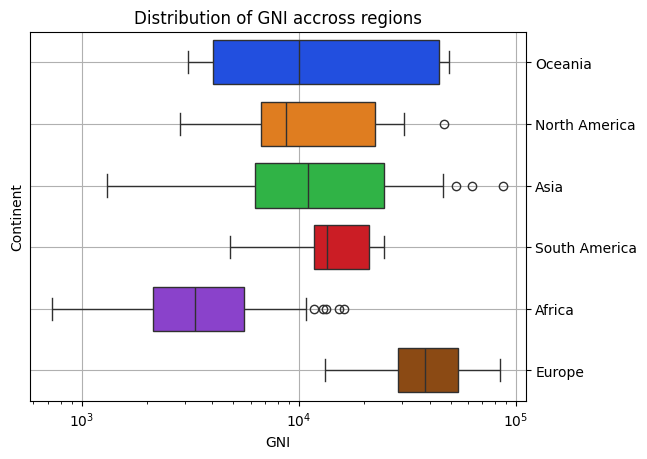

In [39]:
ax = sns.boxplot(
    data=DF,
    x="GNI",
    y="Continent",
    gap=0.4,
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor", "alpha"]},
    legend="auto",
    width=1.2
)

ax.grid()
ax.yaxis.tick_right()
ax.set_xscale("log")


plt.title("Distribution of GNI accross regions")

In [40]:
fig = px.choropleth(
    DF,
    locations='iso_a3',
    color='IQ',
    color_continuous_scale='YlOrRd',
    hover_data="Country"
    
)
fig.update_layout(margin={"r":350,"t":50,"l":100,"b":0}, title_text='Average IQ of countries', title_x=0.5, autosize = True)


fig.show()

In [42]:
DF.head()

,Continent,Country,Literacy,iso_a3,geometry,HDI,LifeExpectancy,ExpectedYearsOfScholing,MeanYearsOfSchooling,GNI,IQ,SchoolingDifference
0,Oceania,Fiji,93.70,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.730,67.1140,14.736790,10.921548,9980.110866,83.96,3.815242
2,North America,Canada,99.00,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",0.936,82.6565,16.396259,13.834427,46807.986190,99.52,2.561832
3,Asia,Kazakhstan,99.79,KAZ,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",0.811,69.3622,15.765000,12.347562,23942.818370,88.89,3.417438
4,Asia,Uzbekistan,100.00,UZB,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...",0.727,70.8616,12.477140,11.895590,7916.785725,89.01,0.581551
5,Oceania,Papua New Guinea,63.43,PNG,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...",0.558,65.3506,10.360771,4.740000,4008.623573,78.49,5.620771
